# **Smart Rice Disease Classifier: Revolutionizing Paddy Crop Health with AI**
- **Name:** Felix Rafael
- **Email:** felixrafaelkwan@gmail.com


### **Objective:**   
The objective of this project is to build a robust and highly accurate deep learning model capable of identifying 8 key rice leaf diseases and healthy leaves. By leveraging the power of deep learning, this model aims to provide a reliable, scalable, and real-time tool that helps farmers monitor crop health and prevent large-scale crop losses due to disease outbreaks.


###**Dataset source:**
https://www.kaggle.com/datasets/loki4514/rice-leaf-diseases-detection

# **1. Import Libraries**

In [36]:
import os
import io
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
import shutil
from PIL import Image
from google.colab import drive, files
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import NumpyArrayIterator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
!pip install tensorflowjs
import tensorflowjs as tfjs

# **2. Data Preparation & Preprocessing**

In [2]:
#Mount Google Drive to access files
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Define the path to the ZIP file
zip_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/RiceLeaf.zip'

In [4]:
#Extract the contents of the ZIP file
extract_dir = '/content/dataset'
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [5]:
#Move the disease subfolders to the base directory
base_dir = '/content/dataset'
aug_dir = os.path.join(base_dir, 'Rice_Leaf_AUG')
if os.path.exists(aug_dir):
    for disease_folder in os.listdir(aug_dir):
        src = os.path.join(aug_dir, disease_folder)
        dst = os.path.join(base_dir, disease_folder)
        if os.path.isdir(src):
            shutil.move(src, dst)
    shutil.rmtree(aug_dir)
    print("Folders have been tidied up to 1 level: dataset/class")

Folders have been tidied up to 1 level: dataset/class


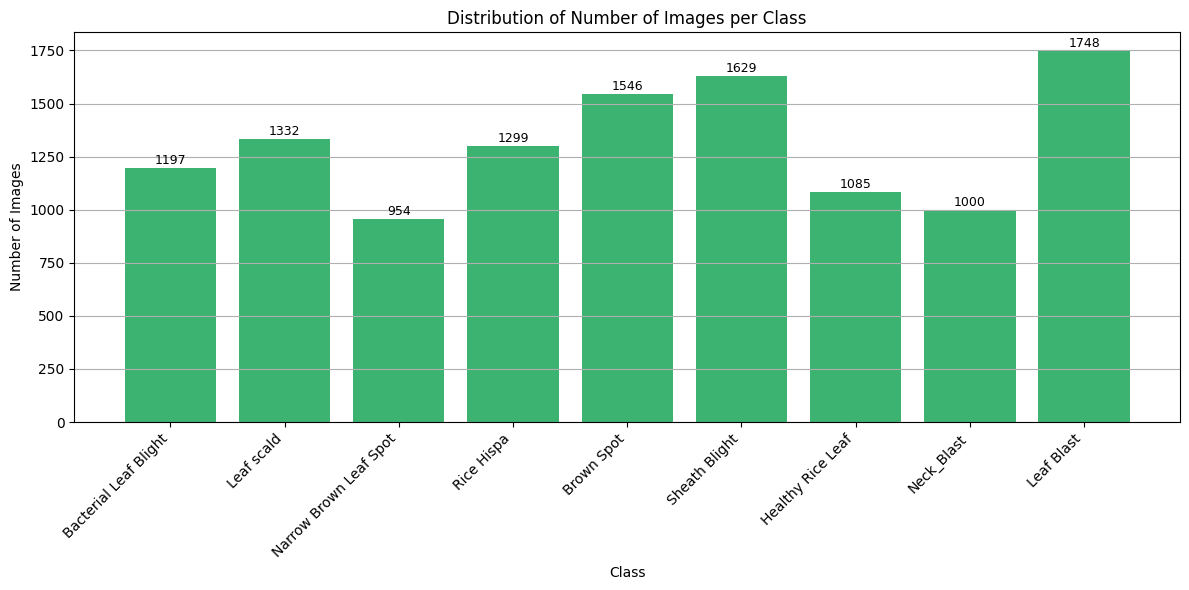

In [6]:
#Visualize the distribution of images per class
classes = {class_name: len(os.listdir(os.path.join(base_dir, class_name)))
                for class_name in os.listdir(base_dir)
                if os.path.isdir(os.path.join(base_dir, class_name))}

plt.figure(figsize=(12, 6))
bars = plt.bar(classes.keys(), classes.values(), color='mediumseagreen')
plt.title("Distribution of Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.grid(axis='y')
plt.xticks(rotation=45, ha='right')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 5, int(yval), ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

Total successfully processed images: 11790


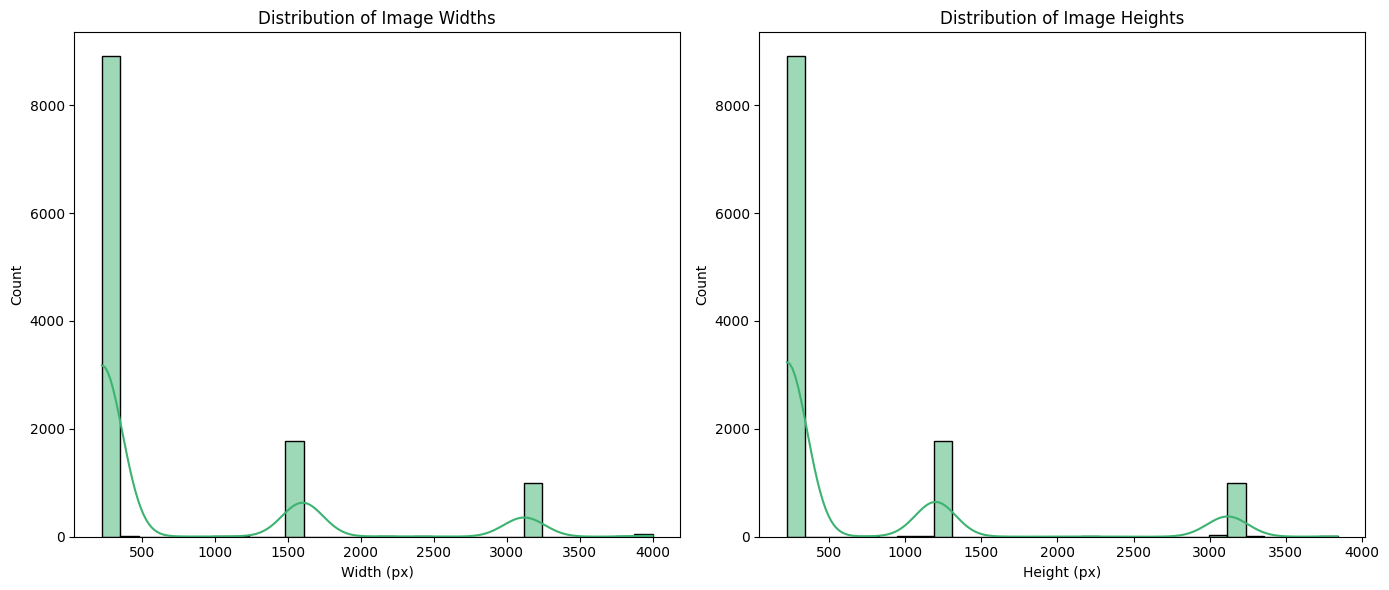

In [7]:
#Visualize the distribution of image width and height
widths = []
heights = []

for class_folder in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_folder)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                with Image.open(img_path) as img:
                    width, height = img.size
                    widths.append(width)
                    heights.append(height)
            except:
                continue
print(f"Total successfully processed images: {len(widths)}")

plt.figure(figsize=(14, 6))
#Width distribution
plt.subplot(1, 2, 1)
sns.histplot(widths, bins=30, kde=True, color='mediumseagreen')
plt.title("Distribution of Image Widths")
plt.xlabel("Width (px)")
plt.ylabel("Count")
#Height distribution
plt.subplot(1, 2, 2)
sns.histplot(heights, bins=30, kde=True, color='mediumseagreen')
plt.title("Distribution of Image Heights")
plt.xlabel("Height (px)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [8]:
#Image size statistics
print(f"Average image size: {np.mean(widths):.2f} x {np.mean(heights):.2f}")
print(f"Minimum size: {min(widths)} x {min(heights)}")
print(f"Maximum size: {max(widths)} x {max(heights)}")

Average image size: 699.78 x 638.71
Minimum size: 224 x 224
Maximum size: 4000 x 3840


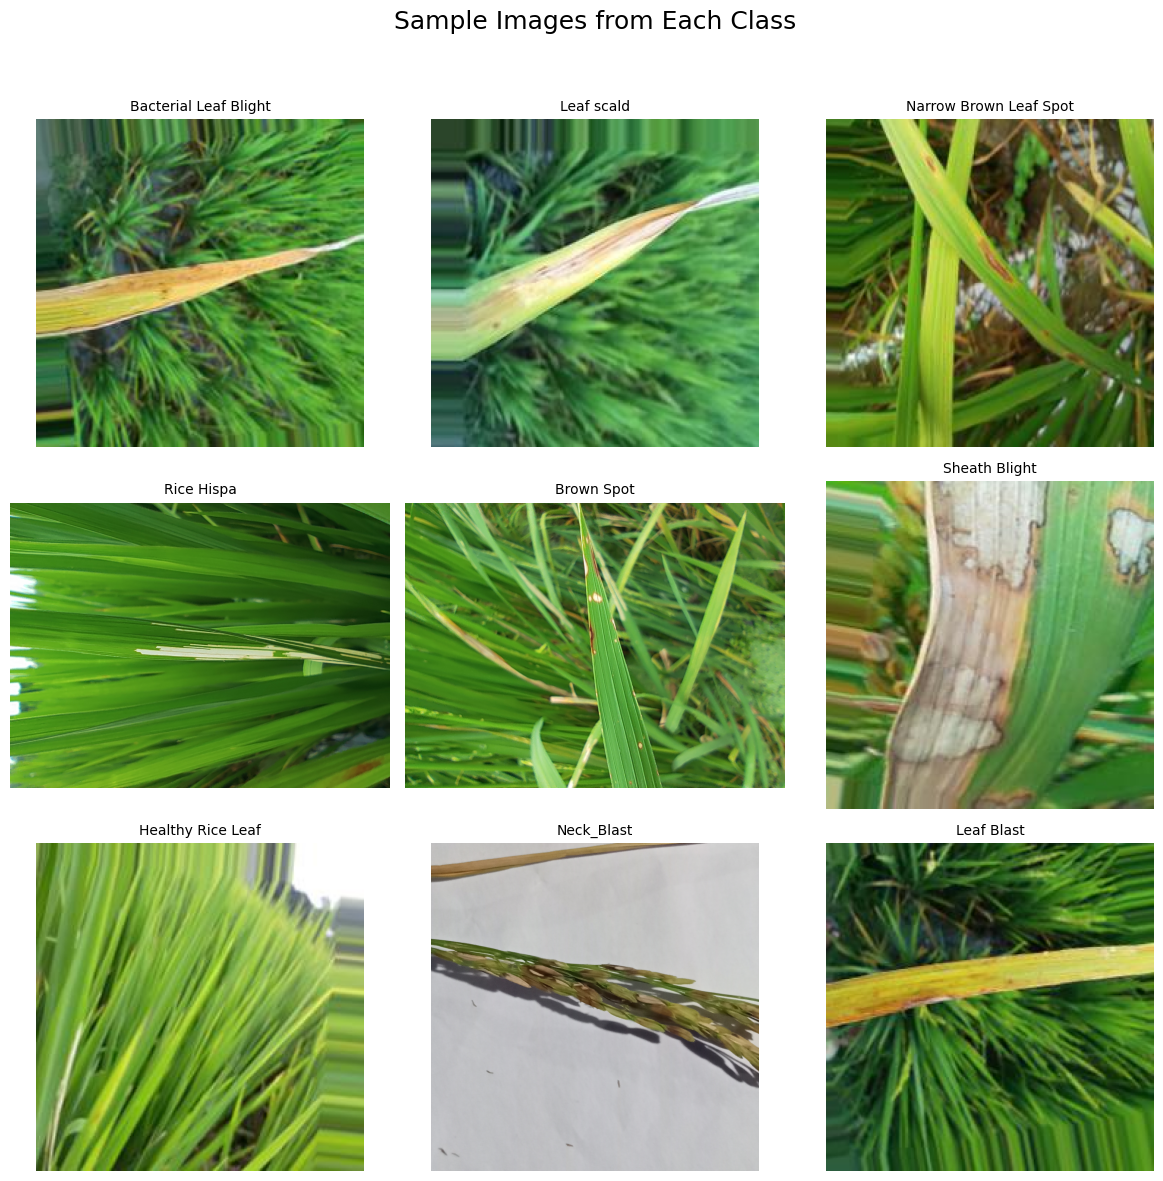

In [9]:
#Display sample images from each class
plt.figure(figsize=(12, 12))
rows, cols = 3, 3

for i, cls in enumerate(classes):
    class_path = os.path.join(base_dir, cls)
    img_file = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_file)

    img = mpimg.imread(img_path)
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(cls, fontsize=10)
    plt.axis('off')

for j in range(len(classes), rows * cols):
    plt.subplot(rows, cols, j + 1)
    plt.axis('off')

plt.suptitle("Sample Images from Each Class", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [10]:
#Define the data split ratios: 80% for training, 10% for validation, and 10% for testing
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

In [11]:
#Define the total ratio for validation + test data
val_test_split = val_ratio + test_ratio

#Initialize the ImageDataGenerator for rescaling and data splitting
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=val_test_split
)

#Create the training data generator from the directory
train_generator = datagen.flow_from_directory(
    'dataset',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

#Create the validation data generator from the directory
val_test_generator = datagen.flow_from_directory(
    'dataset',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

Found 9436 images belonging to 9 classes.
Found 2354 images belonging to 9 classes.


In [12]:
#Split Validation and Test Data from combined validation and testing
x_val_test, y_val_test = [], []

for _ in range(len(val_test_generator)):
    x_batch, y_batch = next(val_test_generator)
    x_val_test.extend(x_batch)
    y_val_test.extend(y_batch)

x_val_test = np.array(x_val_test)
y_val_test = np.array(y_val_test)
x_val, x_test, y_val, y_test = train_test_split(
    x_val_test, y_val_test,
    test_size=0.5,
    random_state=42,
    stratify=np.argmax(y_val_test, axis=1)
)

In [13]:
#Create data generators for validation and test sets from Pre-split Data
val_generator = ImageDataGenerator().flow(
    x_val, y_val, batch_size=32, shuffle=False
)

test_generator = ImageDataGenerator().flow(
    x_test, y_test, batch_size=32, shuffle=False
)

In [14]:
#Print class distribution for Training, Validation, and Test sets
def print_class_distribution(generator, name):
    from collections import Counter
    import numpy as np

    class_indices = generator.class_indices if hasattr(generator, 'class_indices') else None
    if class_indices:
        idx_to_class = {v: k for k, v in class_indices.items()}
        classes = generator.classes
    else:
        idx_to_class = {i: f"Class {i}" for i in range(generator.y.shape[1])}
        classes = np.argmax(generator.y, axis=1)

    class_counts = dict(Counter(classes))
    print(f"\n{name} Set Image Counts per Class:")
    for class_idx, count in class_counts.items():
        print(f"{idx_to_class[class_idx]}: {count} images")

print_class_distribution(train_generator, "Train")
print_class_distribution(val_generator, "Validation")
print_class_distribution(test_generator, "Test")


Train Set Image Counts per Class:
Bacterial Leaf Blight: 958 images
Brown Spot: 1237 images
Healthy Rice Leaf: 868 images
Leaf Blast: 1399 images
Leaf scald: 1066 images
Narrow Brown Leaf Spot: 764 images
Neck_Blast: 800 images
Rice Hispa: 1040 images
Sheath Blight: 1304 images

Validation Set Image Counts per Class:
Class 2: 109 images
Class 7: 129 images
Class 3: 175 images
Class 1: 154 images
Class 4: 133 images
Class 0: 119 images
Class 5: 95 images
Class 8: 163 images
Class 6: 100 images

Test Set Image Counts per Class:
Class 5: 95 images
Class 3: 174 images
Class 2: 108 images
Class 6: 100 images
Class 7: 130 images
Class 0: 120 images
Class 4: 133 images
Class 1: 155 images
Class 8: 162 images


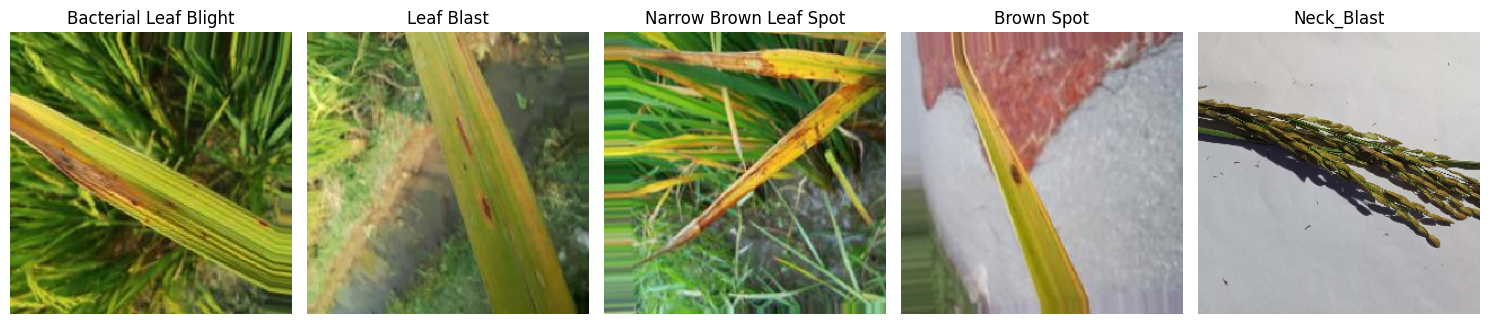

In [15]:
#Display sample images from the Training Set
class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}
sample_image, label = next(train_generator)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(sample_image[i])
    axes[i].axis('off')

    class_idx = np.argmax(label[i])
    class_name = idx_to_class[class_idx]
    axes[i].set_title(f"{class_name}")
plt.tight_layout()
plt.show()

In [16]:
#Calculate class weights for handling class imbalance
labels = train_generator.classes

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))

print("Class weights per class index:")
for class_index, weight in class_weights.items():
    class_name = [k for k, v in train_generator.class_indices.items() if v == class_index][0]
    print(f"{class_index} ({class_name}): {weight:.4f}")

Class weights per class index:
0 (Bacterial Leaf Blight): 1.0944
1 (Brown Spot): 0.8476
2 (Healthy Rice Leaf): 1.2079
3 (Leaf Blast): 0.7494
4 (Leaf scald): 0.9835
5 (Narrow Brown Leaf Spot): 1.3723
6 (Neck_Blast): 1.3106
7 (Rice Hispa): 1.0081
8 (Sheath Blight): 0.8040


# **3. Model Building and Training**

In [21]:
#Load VGG16 Model with Pre-trained weights
vgg_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)
#Freeze all layers for Transfer Learning
for layer in vgg_base.layers:
    layer.trainable = False

In [22]:
#Build CNN Model with VGG16 and Custom Layers
model = Sequential()
model.add(vgg_base)
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(9, activation='softmax'))

In [23]:
#Display the summary of the model architecture
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 128)      │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,453,385 (58.95 MB)

 Trainable params: 738,697 (2.82 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [24]:
#Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
#Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

In [26]:
#Set Up Callbacks: EarlyStopping and ModelCheckpoint
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [27]:
#Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.3515 - loss: 1.7521
Epoch 1: val_accuracy improved from -inf to 0.63381, saving model to best_model.h5


295/295 ━━━━━━━━━━━━━━━━━━━━ 150s 443ms/step - accuracy: 0.3519 - loss: 1.7511 - val_accuracy: 0.6338 - val_loss: 1.0280 - learning_rate: 5.0000e-04
Epoch 2/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.6599 - loss: 0.9596
Epoch 2: val_accuracy improved from 0.63381 to 0.74087, saving model to best_model.h5


295/295 ━━━━━━━━━━━━━━━━━━━━ 93s 315ms/step - accuracy: 0.6600 - loss: 0.9593 - val_accuracy: 0.7409 - val_loss: 0.7666 - learning_rate: 5.0000e-04
Epoch 3/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.7791 - loss: 0.6279
Epoch 3: val_accuracy improved from 0.74087 to 0.76720, saving model to best_model.h5


295/295 ━━━━━━━━━━━━━━━━━━━━ 143s 318ms/step - accuracy: 0.7792 - loss: 0.6278 - val_accuracy: 0.7672 - val_loss: 0.6690 - learning_rate: 5.0000e-04
Epoch 4/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.8463 - loss: 0.4496
Epoch 4: val_accuracy improved from 0.76720 to 0.85472, saving model to best_model.h5


295/295 ━━━━━━━━━━━━━━━━━━━━ 139s 307ms/step - accuracy: 0.8464 - loss: 0.4494 - val_accuracy: 0.8547 - val_loss: 0.4601 - learning_rate: 5.0000e-04
Epoch 5/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9031 - loss: 0.2947
Epoch 5: val_accuracy improved from 0.85472 to 0.87256, saving model to best_model.h5


295/295 ━━━━━━━━━━━━━━━━━━━━ 93s 313ms/step - accuracy: 0.9031 - loss: 0.2946 - val_accuracy: 0.8726 - val_loss: 0.3783 - learning_rate: 5.0000e-04
Epoch 6/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9292 - loss: 0.1991
Epoch 6: val_accuracy improved from 0.87256 to 0.90484, saving model to best_model.h5


295/295 ━━━━━━━━━━━━━━━━━━━━ 93s 316ms/step - accuracy: 0.9293 - loss: 0.1990 - val_accuracy: 0.9048 - val_loss: 0.2801 - learning_rate: 5.0000e-04
Epoch 7/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9585 - loss: 0.1306
Epoch 7: val_accuracy did not improve from 0.90484
295/295 ━━━━━━━━━━━━━━━━━━━━ 89s 301ms/step - accuracy: 0.9585 - loss: 0.1306 - val_accuracy: 0.8811 - val_loss: 0.3312 - learning_rate: 5.0000e-04
Epoch 8/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9662 - loss: 0.1088
Epoch 8: val_accuracy improved from 0.90484 to 0.91504, saving model to best_model.h5


295/295 ━━━━━━━━━━━━━━━━━━━━ 89s 301ms/step - accuracy: 0.9662 - loss: 0.1088 - val_accuracy: 0.9150 - val_loss: 0.2667 - learning_rate: 5.0000e-04
Epoch 9/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9784 - loss: 0.0674
Epoch 9: val_accuracy improved from 0.91504 to 0.92863, saving model to best_model.h5


295/295 ━━━━━━━━━━━━━━━━━━━━ 91s 309ms/step - accuracy: 0.9784 - loss: 0.0674 - val_accuracy: 0.9286 - val_loss: 0.2292 - learning_rate: 5.0000e-04
Epoch 10/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9762 - loss: 0.0735
Epoch 10: val_accuracy did not improve from 0.92863
295/295 ━━━━━━━━━━━━━━━━━━━━ 89s 301ms/step - accuracy: 0.9762 - loss: 0.0735 - val_accuracy: 0.9142 - val_loss: 0.3147 - learning_rate: 5.0000e-04
Epoch 11/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9872 - loss: 0.0435
Epoch 11: val_accuracy improved from 0.92863 to 0.94562, saving model to best_model.h5


295/295 ━━━━━━━━━━━━━━━━━━━━ 91s 307ms/step - accuracy: 0.9872 - loss: 0.0435 - val_accuracy: 0.9456 - val_loss: 0.1887 - learning_rate: 5.0000e-04
Epoch 12/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9896 - loss: 0.0322
Epoch 12: val_accuracy did not improve from 0.94562
295/295 ━━━━━━━━━━━━━━━━━━━━ 91s 307ms/step - accuracy: 0.9896 - loss: 0.0322 - val_accuracy: 0.9167 - val_loss: 0.2904 - learning_rate: 5.0000e-04
Epoch 13/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9901 - loss: 0.0360
Epoch 13: val_accuracy did not improve from 0.94562
295/295 ━━━━━━━━━━━━━━━━━━━━ 93s 314ms/step - accuracy: 0.9901 - loss: 0.0360 - val_accuracy: 0.9244 - val_loss: 0.2481 - learning_rate: 5.0000e-04
Epoch 14/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9902 - loss: 0.0296
Epoch 14: val_accuracy did not improve from 0.94562
295/295 ━━━━━━━━━━━━━━━━━━━━ 93s 316ms/step - accuracy: 0.9902 - loss: 0.0296 - val_accuracy: 0.9337 - val_loss: 0.2384 - learning_ra

295/295 ━━━━━━━━━━━━━━━━━━━━ 95s 320ms/step - accuracy: 0.9977 - loss: 0.0100 - val_accuracy: 0.9592 - val_loss: 0.1851 - learning_rate: 2.5000e-04
Epoch 18/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9991 - loss: 0.0057
Epoch 18: val_accuracy did not improve from 0.95922
295/295 ━━━━━━━━━━━━━━━━━━━━ 92s 310ms/step - accuracy: 0.9991 - loss: 0.0057 - val_accuracy: 0.9482 - val_loss: 0.2036 - learning_rate: 2.5000e-04
Epoch 19/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.9986 - loss: 0.0072
Epoch 19: val_accuracy did not improve from 0.95922
295/295 ━━━━━━━━━━━━━━━━━━━━ 90s 305ms/step - accuracy: 0.9986 - loss: 0.0072 - val_accuracy: 0.9516 - val_loss: 0.1891 - learning_rate: 2.5000e-04
Epoch 20/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9995 - loss: 0.0030
Epoch 20: val_accuracy improved from 0.95922 to 0.96347, saving model to best_model.h5


295/295 ━━━━━━━━━━━━━━━━━━━━ 93s 313ms/step - accuracy: 0.9995 - loss: 0.0030 - val_accuracy: 0.9635 - val_loss: 0.1870 - learning_rate: 2.5000e-04
Epoch 21/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9986 - loss: 0.0064
Epoch 21: val_accuracy did not improve from 0.96347
295/295 ━━━━━━━━━━━━━━━━━━━━ 140s 307ms/step - accuracy: 0.9986 - loss: 0.0064 - val_accuracy: 0.9295 - val_loss: 0.2546 - learning_rate: 2.5000e-04
Epoch 22/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9985 - loss: 0.0075
Epoch 22: val_accuracy improved from 0.96347 to 0.96432, saving model to best_model.h5


295/295 ━━━━━━━━━━━━━━━━━━━━ 90s 303ms/step - accuracy: 0.9985 - loss: 0.0075 - val_accuracy: 0.9643 - val_loss: 0.1707 - learning_rate: 2.5000e-04
Epoch 23/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.9975 - loss: 0.0059
Epoch 23: val_accuracy did not improve from 0.96432
295/295 ━━━━━━━━━━━━━━━━━━━━ 88s 298ms/step - accuracy: 0.9975 - loss: 0.0059 - val_accuracy: 0.9592 - val_loss: 0.1890 - learning_rate: 2.5000e-04
Epoch 24/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9970 - loss: 0.0086
Epoch 24: val_accuracy improved from 0.96432 to 0.96517, saving model to best_model.h5


295/295 ━━━━━━━━━━━━━━━━━━━━ 89s 301ms/step - accuracy: 0.9970 - loss: 0.0086 - val_accuracy: 0.9652 - val_loss: 0.1620 - learning_rate: 2.5000e-04
Epoch 25/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9995 - loss: 0.0035
Epoch 25: val_accuracy did not improve from 0.96517
295/295 ━━━━━━━━━━━━━━━━━━━━ 92s 312ms/step - accuracy: 0.9995 - loss: 0.0035 - val_accuracy: 0.9380 - val_loss: 0.2155 - learning_rate: 2.5000e-04
Epoch 26/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9935 - loss: 0.0193
Epoch 26: val_accuracy did not improve from 0.96517
295/295 ━━━━━━━━━━━━━━━━━━━━ 138s 299ms/step - accuracy: 0.9935 - loss: 0.0193 - val_accuracy: 0.9482 - val_loss: 0.2041 - learning_rate: 2.5000e-04
Epoch 27/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9977 - loss: 0.0071
Epoch 27: val_accuracy did not improve from 0.96517
295/295 ━━━━━━━━━━━━━━━━━━━━ 91s 307ms/step - accuracy: 0.9977 - loss: 0.0071 - val_accuracy: 0.9499 - val_loss: 0.2122 - learning_r

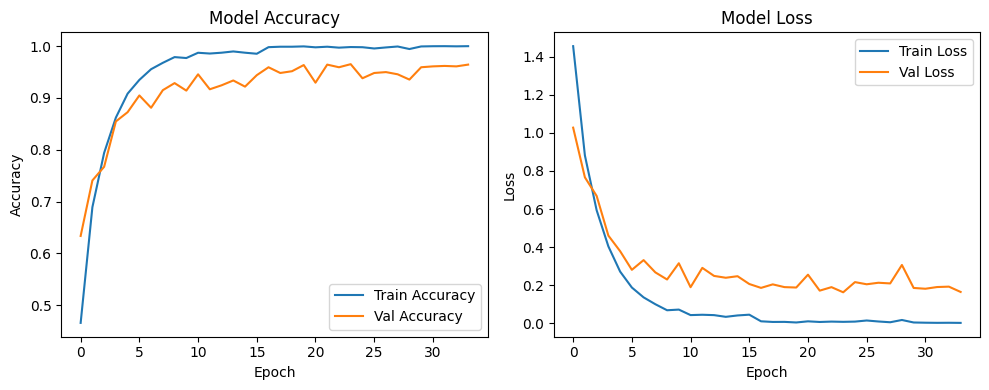

In [28]:
#Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# **4. Model Evaluation and Testing**

In [30]:
#Load the best saved model and evaluate it on the test set
model = load_model('best_model.h5')
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")
print(f"📉 Test Loss: {test_loss:.4f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 243ms/step - accuracy: 0.9468 - loss: 0.3192

✅ Test Accuracy: 0.9516
📉 Test Loss: 0.2228


In [31]:
#Get predictions from the model
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)
class_labels = list(train_generator.class_indices.keys())

37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 262ms/step


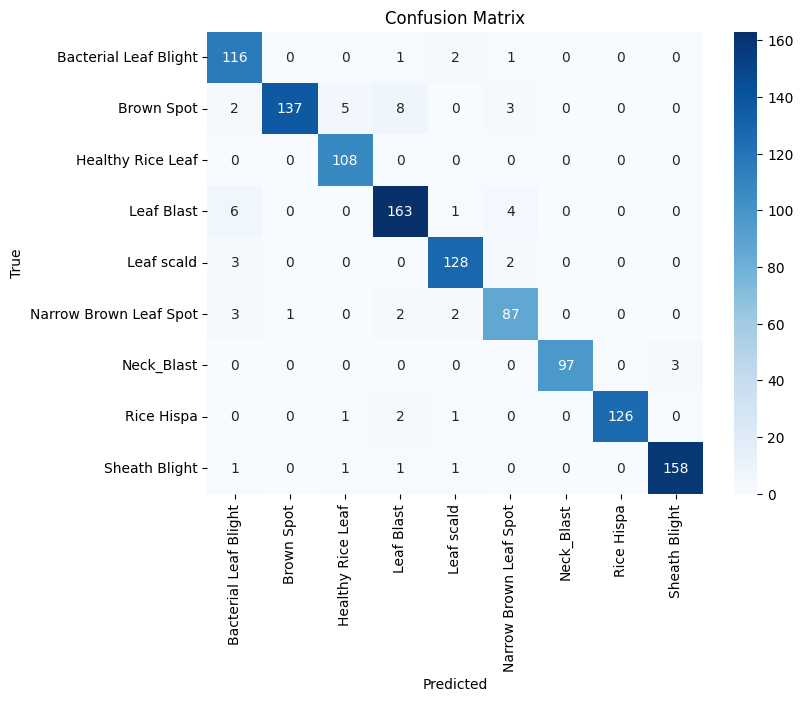

                        precision    recall  f1-score   support

 Bacterial Leaf Blight       0.89      0.97      0.92       120
            Brown Spot       0.99      0.88      0.94       155
     Healthy Rice Leaf       0.94      1.00      0.97       108
            Leaf Blast       0.92      0.94      0.93       174
            Leaf scald       0.95      0.96      0.96       133
Narrow Brown Leaf Spot       0.90      0.92      0.91        95
            Neck_Blast       1.00      0.97      0.98       100
            Rice Hispa       1.00      0.97      0.98       130
         Sheath Blight       0.98      0.98      0.98       162

              accuracy                           0.95      1177
             macro avg       0.95      0.95      0.95      1177
          weighted avg       0.95      0.95      0.95      1177



In [32]:
#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#Classification Report
print(classification_report(y_true, y_pred, target_names=class_labels))

# **5. Saving Model for Deployment**

In [33]:
#Save the trained model in multiple formats: SavedModel, TFLite, and TFJS
#SavedModel
model.export('/content/drive/MyDrive/saved_model')
# TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/MyDrive/saved_model')
tflite_model = converter.convert()
with open('/content/drive/MyDrive/model.tflite', 'wb') as f:
    f.write(tflite_model)
# TFJS
tfjs.converters.save_keras_model(model, '/content/drive/MyDrive/tfjs_model')

Saved artifact at '/content/drive/MyDrive/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)
Captures:
  136866786756944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136866880879504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136866786759632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136866651082384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136866651081808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136866651080656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136866651082768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136866651079696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136866651081616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136866651083536: TensorSpec(shape=(), dtype=tf.resource, name=Non

failed to lookup keras version from the file,
    this is likely a weight only file


# **6. Inference: Making Predictions with the Saved Model**

Saving images.jpeg to images.jpeg


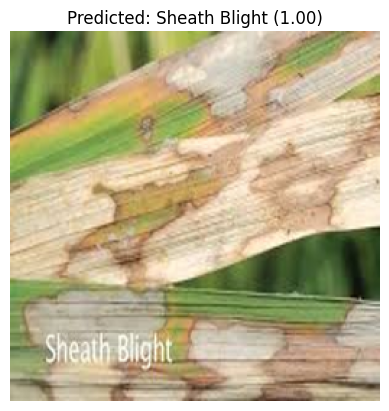

The image is predicted as: Sheath Blight
Confidence score: 1.0000


In [42]:
#Image classification with TFLite model
uploaded = files.upload()
img_path = next(iter(uploaded))
img = Image.open(img_path).resize((256, 256))
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], img_array)
interpreter.invoke()
pred = interpreter.get_tensor(output_details[0]['index'])
pred_label = np.argmax(pred)

with open("/content/drive/MyDrive/label.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]

plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted: {labels[pred_label]} ({np.max(pred):.2f})")
plt.show()
print(f"The image is predicted as: {labels[pred_label]}")
print(f"Confidence score: {np.max(pred):.4f}")

# **Conclusion**

In this project, we successfully developed a deep learning model for classifying rice leaf diseases using Convolutional Neural Networks (CNN). The model was trained on a dataset containing images of 9 classes: 8 rice leaf diseases and healthy rice leaves. The model architecture utilized the VGG16 base as a feature extractor, followed by custom layers to enhance classification performance.

#### **Training & Performance**
During training, the model achieved a remarkable **accuracy of 99.70%** on the training set, with a **loss of 0.0086**. This demonstrates that the model effectively learned the patterns from the data, even with the complexities of leaf diseases in rice plants.

The validation performance was also strong, with the validation accuracy reaching **96.52%** and a loss of **0.3192** by the 24th epoch. The model was able to generalize well on unseen data, showing minimal overfitting between the training and validation sets. The **best model** was saved during training using the `ModelCheckpoint` callback based on the highest validation accuracy.

#### **Testing & Final Evaluation**
After training, the model was evaluated on the test set, where it achieved a **test accuracy of 95.16%** and a **test loss of 0.2228**. This indicates that the model performs reliably on unseen data, confirming its effectiveness in real-world scenarios.

#### **Model Export & Inference**
The model was saved in multiple formats, including TensorFlow Lite (TFLite) and TensorFlow.js (TFJS), for efficient deployment on different platforms. Inference was performed on uploaded test images, and predictions were made with high confidence, showing the model's robustness and readiness for practical applications.

#### **Future Work**
- **Improving Model Accuracy**: Although the model performs excellently, there is always room for enhancement. Techniques such as data augmentation, fine-tuning, and experimenting with deeper architectures could be explored to further boost accuracy.
- **Real-time Deployment**: The TFLite and TFJS versions of the model are ready for deployment on mobile devices and web applications, allowing real-time detection of rice leaf diseases in the field.
- **Integration with Agricultural Systems**: This model can be integrated into agricultural tools or mobile apps, providing farmers with real-time diagnostics to manage crop health and prevent disease spread.

Overall, this project demonstrates the power of deep learning for agricultural applications, specifically in the detection of rice leaf diseases, which can significantly benefit farmers by providing early disease identification and helping mitigate large-scale crop losses.